# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [ ]:
!python -m pip install torchmetrics

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from torchmetrics import Accuracy

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда.



In [8]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3,
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader


In [9]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64,
                                                         transform_train=transform)

100%|██████████| 170498071/170498071 [00:05<00:00, 28605593.99it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Посмотрим на изображения:

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([3, 36, 138])


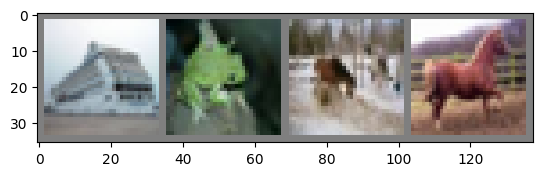

ship frog horse horse


In [10]:
def imshow(img):
    print(img.shape)
    img = img / 2 + 0.5
    npimg = img.numpy()

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
# images, labels = dataiter.next()
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

Для реализации взял пример из официальной документации pytorch по ResNet:

https://pytorch.org/vision/0.8/_modules/torchvision/models/resnet.html

In [11]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self, downsample= None):
        super(BasicBlockNet, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 32, kernel_size= 3, stride= 1, padding= 1),
                        nn.BatchNorm2d(32),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(32, 32, kernel_size = 3, stride = 1, padding= 1),
                        nn.BatchNorm2d(32))
        self.relu = nn.ReLU()
        self.conv1x1 = nn.Conv2d(3, 32, kernel_size = 1)
        self.avgpool = nn.AvgPool2d(16, stride= 5)
        self.fc = nn.Linear(32*4*4, n_classes)
        self.downsample = downsample


    def forward(self, x):
        residual = x
        out = self.conv1(x)
        # print('Первый слой:', out.shape)
        out = self.conv2(out)
        # print('Второй слой:', out.shape)
        if self.downsample:
            residual = self.downsample(x)
        # print('Размерность residual:', residual.shape)
        out += self.conv1x1(residual)
        # print('Размерность residual после слоя:', out.shape)
        out = self.relu(out)
        out = self.avgpool(out)
        # print('Размерность после avgpool:', out.shape)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [12]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu): ReLU()
  (conv1x1): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (avgpool): AvgPool2d(kernel_size=16, stride=5, padding=0)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [13]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [15]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [16]:
def test(model, loader, criterion, metric):
    loss_log = []
    acc_log = []
    model.eval()

    for data, target in loader:

        # <your code here>
        data, target = data.to(device), target.to(device)
        predict = model(data)
        loss = criterion(predict, target)
        loss_log.append(loss.item())

        # <your code here>
        acc = metric(predict, target)
        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, criterion, metric, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:
        # <your code here>
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        predict = model(data)
        loss = criterion(predict, target)
        loss_log.append(loss.item())
        loss.backward()
        optimizer.step()

        # <your code here>
        acc = metric(predict, target)
        acc_log.append(acc.item())

    return loss_log, acc_log

def train(model, optimizer, criterion, metric, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, criterion, metric, train_loader)
        val_loss, val_acc = test(model, val_loader, criterion, metric)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [17]:
optimizer = optim.SGD(net.parameters(), lr= 0.1, momentum= 0.9)
criterion = nn.CrossEntropyLoss()
metric = Accuracy(task= 'multiclass', num_classes= n_classes).to(device)

train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, criterion, metric, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.5460570128787805, train acc: 0.4418826716691528
 val loss: 1.3342509011004833, val acc: 0.5246453900286492

Epoch 1
 train loss: 1.2581824171041875, train acc: 0.5561749151681415
 val loss: 1.1924610584340196, val acc: 0.5880540780564572

Epoch 2
 train loss: 1.134916402957993, train acc: 0.6024826978634654
 val loss: 1.0949353015169185, val acc: 0.6181072695458188

Epoch 3
 train loss: 1.0583601221306014, train acc: 0.6285869352778307
 val loss: 1.0617950589098828, val acc: 0.6249113476022761

Epoch 4
 train loss: 1.015485326158499, train acc: 0.647545867035986
 val loss: 1.0038965313992603, val acc: 0.6490248226104899

Epoch 5
 train loss: 0.985742855333541, train acc: 0.657584388905513
 val loss: 1.0079231153143213, val acc: 0.6539893617021276

Epoch 6
 train loss: 0.9498814085065992, train acc: 0.6722993928074182
 val loss: 1.0224828793647442, val acc: 0.6580452127659574

Epoch 7
 train loss: 0.9305052549682108, train acc: 0.6756414860432501
 val loss: 0.9425

Посчитайте точность на тестовой выборке:

In [19]:
# <your code here>
print(f'Test score: {test(net, test_loader, criterion, metric)[1]}')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test score: 0.7070063694267515


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

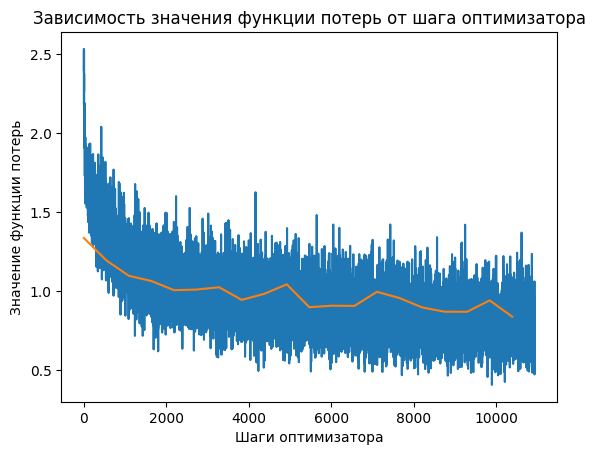

In [40]:
# <your code here>
plt.title('Зависимость значения функции потерь от шага оптимизатора')
plt.plot(train_loss_log)

val_step = [len(train_loader) * step for step in range(len(val_loss_log))]
plt.plot(val_step, val_loss_log)

plt.xlabel('Шаги оптимизатора')
plt.ylabel('Значение функции потерь')
plt.show()

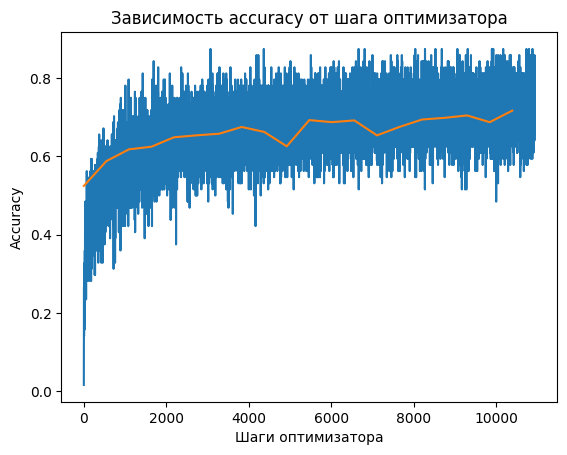

In [41]:
plt.title('Зависимость accuracy от шага оптимизатора')
plt.plot(train_acc_log)

val_step = [len(train_loader) * step for step in range(len(val_acc_log))]
plt.plot(val_step, val_acc_log)

plt.xlabel('Шаги оптимизатора')
plt.ylabel('Accuracy')
plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [44]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, criterion, metric, 20, train_loader, val_loader, scheduler)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 0
 train loss: 1.5420004388749926, train acc: 0.44186226824737773
 val loss: 1.361585907225913, val acc: 0.513608155986096

Epoch 1
 train loss: 1.2251517495899793, train acc: 0.5653279250457038
 val loss: 1.3768051629370832, val acc: 0.5226507093044037

Epoch 2
 train loss: 1.1072286101538258, train acc: 0.613337359655056
 val loss: 1.082178086676496, val acc: 0.6257757093044037

Epoch 3
 train loss: 1.043633533352254, train acc: 0.6368952402249115
 val loss: 1.0678050297371884, val acc: 0.629033688027808

Epoch 4
 train loss: 1.008887870656071, train acc: 0.6499575607519481
 val loss: 0.9511133478042927, val acc: 0.672030141759426

Epoch 5
 train loss: 0.9615231011423812, train acc: 0.6647949856203696
 val loss: 0.9606878732113128, val acc: 0.6747783688788719

Epoch 6
 train loss: 0.9430796301343105, train acc: 0.673429746623449
 val loss: 0.9182970947407662, val acc: 0.6841976949509154

Epoch 7
 train loss: 0.9284386374396859, train acc: 0.6763229629457324
 val loss: 1.0381890

Посчитайте точность на тестовой выборке:

In [45]:
# <your code here>
print(f'Test score: {test(net, test_loader, criterion, metric)[1]}')

Test score: 0.7217356687898089


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [50]:
# <your code here>
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr= 0.001, momentum= 0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, criterion, metric, 20, train_loader, val_loader)
print(f'Test score: {test(net, test_loader, criterion, metric)[1]}')

Epoch 0
 train loss: 1.8637765338695462, train acc: 0.3340909833010198
 val loss: 1.6843402827039677, val acc: 0.4026817376309253

Epoch 1
 train loss: 1.6139348669069558, train acc: 0.4231114520996101
 val loss: 1.5365137105292461, val acc: 0.4544991134329045

Epoch 2
 train loss: 1.5008728778776346, train acc: 0.46386132150942927
 val loss: 1.4511870262470652, val acc: 0.48388741130524493

Epoch 3
 train loss: 1.4216048181383876, train acc: 0.49434823059294736
 val loss: 1.375866202090649, val acc: 0.5126108155605641

Epoch 4
 train loss: 1.3718189504508345, train acc: 0.5114014755655251
 val loss: 1.3618212081016379, val acc: 0.5142287234042553

Epoch 5
 train loss: 1.3269635371359871, train acc: 0.5292137307702296
 val loss: 1.2936553478240966, val acc: 0.5486702127659574

Epoch 6
 train loss: 1.2907864369683553, train acc: 0.5431085139567499
 val loss: 1.2764686777236613, val acc: 0.5486923759287976

Epoch 7
 train loss: 1.2608147643819805, train acc: 0.5559586380255942
 val loss:

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [81]:
# <your code here>
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr= 0.1, momentum= 0.9)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor= 1.0, end_factor= 0.01, total_iters= 20)

tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, criterion, metric, 20, train_loader, val_loader, scheduler)
print(f'Test score: {test(net, test_loader, criterion, metric)[1]}')


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 0
 train loss: 1.5985129005948193, train acc: 0.4240989814728662
 val loss: 1.485449062002466, val acc: 0.4748891844394359

Epoch 1
 train loss: 1.2806801977933433, train acc: 0.5452345586781964
 val loss: 1.2086226600281735, val acc: 0.5673537234042553

Epoch 2
 train loss: 1.1491912250327019, train acc: 0.5940438103632256
 val loss: 1.0783255759705888, val acc: 0.6204565602414152

Epoch 3
 train loss: 1.0662421476252555, train acc: 0.6273464024393824
 val loss: 1.087571813197846, val acc: 0.618062943346957

Epoch 4
 train loss: 1.0192636784295495, train acc: 0.6439956581352834
 val loss: 1.039712541661364, val acc: 0.6375664893617021

Epoch 5
 train loss: 0.9806397217283301, train acc: 0.6583964481432215
 val loss: 1.0163722535397144, val acc: 0.6458111702127659

Epoch 6
 train loss: 0.9486965126267735, train acc: 0.669002187208458
 val loss: 1.0220598791507964, val acc: 0.6468528369639782

Epoch 7
 train loss: 0.9219237485359094, train acc: 0.6811871572212066
 val loss: 0.9401

In [53]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr= 0.1, momentum= 0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size= 5, gamma= 0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, criterion, metric, 20, train_loader, val_loader, scheduler)
print(f'Test score: {test(net, test_loader, criterion, metric)[1]}')

Epoch 0
 train loss: 1.6079534011087644, train acc: 0.41370543875685556
 val loss: 1.4565788578479848, val acc: 0.46795212765957445

Epoch 1
 train loss: 1.3065010566380169, train acc: 0.5374322603346007
 val loss: 1.323965983948809, val acc: 0.5456781914893617

Epoch 2
 train loss: 1.16899140225468, train acc: 0.5894367001828154
 val loss: 1.1526207967007414, val acc: 0.6081338652904997

Epoch 3
 train loss: 1.0952138294903409, train acc: 0.6183443784277879
 val loss: 1.1475756112565385, val acc: 0.5973404255319149

Epoch 4
 train loss: 1.050743643718838, train acc: 0.6345121115173674
 val loss: 1.011229969085531, val acc: 0.6539893617021276

Epoch 5
 train loss: 0.9112758431617695, train acc: 0.6866104074326468
 val loss: 0.9213241024220243, val acc: 0.6841533688788718

Epoch 6
 train loss: 0.889077723135242, train acc: 0.695441042047532
 val loss: 0.9081767011196056, val acc: 0.6901817375041069

Epoch 7
 train loss: 0.8764837455052127, train acc: 0.6984117915904936
 val loss: 0.9045

Your answers here:

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [ ]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Посчитайте точность на тестовой выборке:

In [ ]:
# <your code here>

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [ ]:
# <your code here>

Your answers here:

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [ ]:
# <your code here>